# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp, John Townend and El Mestel at [Victoria University of Wellington-Te Herenga Waka](https://www.wgtn.ac.nz) for use by Earth Science graduate students. 

The notebooks cover material that we think will be of particular benefit to those students with little or no previous experience of computer-based data analysis. We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2024, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451). Space permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact El, Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| **[2B](ESCI451_Module_2B.ipynb)** | **Using Pandas to load, peruse and plot data** | **Earthquake catalogue**  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; GNSS data |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with PyGMT | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Gridded data and vectors | Ashfall data and GNSS |
| [Scripting](ESCI451_Module_5A_Scripting.ipynb) | Moving from notebooks to scripts and the command line | - |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# This notebook

1. An introduction to Pandas and dataframes
   - Loading data into a dataframe
   - Visualising the datafame
   - Dataframe statistics
   - Sorting and slicing a dataframe
   - Editing dataframes
   - Loading Excel data (stop using excel!!!)

# An introduction to Pandas and dataframes
 
<img alt="Pandas logo" align="right" style="width:30%" src="https://upload.wikimedia.org/wikipedia/commons/e/ed/Pandas_logo.svg">

So far we have looked at some fairly simple datasets.  NumPy is great for multi-dimensional arrays, but
book-keeping can be tricky and somewhat counterintuitive.  Pandas is our friend here.  Pandas adds meta-data to our data, and allows
us to interact with data using names and words, rather than indexes. This can mean that we can
write much clearer code (yay).  It's also really good at working with data that you would have previously
interacted with in spreadsheets.  Spreadsheets are the source of **many** errors, and keeping data and
results in the same file is almost criminal! Your data are sacred and should **never be in the same
file that you process them in!**.

Pandas [github README](https://github.com/pandas-dev/pandas/blob/main/README.md) outlines why you should
care about Pandas:

> **pandas** is a Python package providing fast, flexible, and expressive data structures designed to 
make working with "relational" or "labeled" data both easy and intuitive. It aims to be the 
fundamental high-level building block for doing practical, **real world** data analysis in Python.
Additionally, it has the broader goal of becoming the **most powerful and flexible open source 
data analysis / manipulation tool available in any language**. It is already well on its way towards 
this goal.

When Pandas says **real world** think messy data. Measurements of properties of the Earth are *almost always*
messy: data are missed when power fails or equipment breaks or when it is too wet to get into the field,
almost all Earth science datasets are noisy, and almost all Earth science data are multi-dimensional and
relational (e.g. multiple variables at one particular place and/or time).  Pandas is really good at coping
with this mess, and **will make your life easier!**

In [1]:
# Enable interactive plots.
%matplotlib widget

## Loading data into a dataframe

To explore some of the functionality of Pandas, we need a dataset. One large and freely accesible
geoscience dataset in New Zealand is the GeoNet eatrhquake catalogue. This contains hundreds of thousands
of earthquakes, so should be fun to play around with.

To start off with, we need to get the data.  We could manually query the 
[Quake Search](https://quakesearch.geonet.org.nz/) web-app, but that means we need to
click lots of buttons, and isn't great for just exploring a dataset.  Lets do it
programatically.  We will build a function, but let's look at the steps along the way.

### Building a query

The Quake Search page can be queried by generating a specific web request in the form:

`"https://quakesearch.geonet.org.nz/csv?bbox={min-longitude},{min-latitude},{max-longitude},{max-latitude}&minmag={min-magnitude}&maxmag={max-magnitude}&mindepth={min-depth}&maxdepth={max-depth}&startdate={start-time}&enddate={end-time}"`

We can build that as a string really easily using variables in place of the curly-brackets things:

In [2]:
format_string = (
    "https://quakesearch.geonet.org.nz/csv?bbox="
    "{min_longitude},{min_latitude},{max_longitude},"
    "{max_latitude}&minmag={min_magnitude}"
    "&maxmag={max_magnitude}&mindepth={min_depth}"
    "&maxdepth={max_depth}&startdate={start_time}"
    "&enddate={end_time}")

min_latitude = -49.0
max_latitude = -40.0
min_longitude = 164.0
max_longitude = 182.0
min_magnitude = 0.0
max_magnitude = 9.0
min_depth = 0.0  # in km
max_depth = 500.0
start_time = "2016-1-1T00:00:00"
end_time = "2017-1-1T00:00:00"

query_string = format_string.format(
    min_latitude=min_latitude,
    max_latitude=max_latitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_magnitude=min_magnitude,
    max_magnitude=max_magnitude,
    min_depth=min_depth,
    max_depth=max_depth,
    start_time=start_time,
    end_time=end_time)

print(query_string)

https://quakesearch.geonet.org.nz/csv?bbox=164.0,-49.0,182.0,-40.0&minmag=0.0&maxmag=9.0&mindepth=0.0&maxdepth=500.0&startdate=2016-1-1T00:00:00&enddate=2017-1-1T00:00:00


See what we did? We specified the format of the query string, then specified the particular search criteria we were interested in, and then put those two elements together to construct the query string. Because we have used variables in place of parts of the string, we can change our query really easily.  

If you click that link we just constructed you should download a file called *earthquakes.csv*. What we really want though is to download that file and look at it in Python straight away.  To do that
we can use the `requests` package to make a web-request:

In [3]:
import requests

response = requests.get(query_string)
print(response)

<Response [200]>


All being well, that should have output `<Response [200]>`. The value of 200 is simply a return code saying that things went as planned.

The `Response` object contains the content that we requested from the web as a `.contents` attribute.  Lets have a look at the first 1000 elements of the response:

In [4]:
print(response.content[0:1000])

b'publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,evaluationmethod,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty\n2016p989175,,2016-12-31T23:52:52.120Z,2016-12-31T23:54:55.286Z,173.5246015,-42.36346146,2.264764032,24.21875,M,,NonLinLoc,,automatic,nz3drx,13,13,4,0.05352924243,142.4724307,0.4842318456,0\n2016p989152,,2016-12-31T23:40:47.629Z,2016-12-31T23:42:45.222Z,172.8047124,-41.32588288,2.093990802,93.125,M,,NonLinLoc,,automatic,nz3drx,11,11,5,0.08099277781,96.62645662,1.346350575,0\n2016p989150,,2016-12-31T23:39:27.175Z,2016-12-31T23:41:11.310Z,174.4267067,-41.57895903,2.38862667,19.53125,M,,NonLinLoc,,automatic,nz3drx,16,16,10,0.2357242155,129.3912933,0.2855492713,0\n2016p989125,,2016-12-31T23:26:14.146Z,2016-12-31T23:29:28.200Z,173.6275937,-42.10946885,2.833114336,49.53125,M,,NonLinLoc,,automatic,nz3drx,28,28,13,

This is the contents of the `earthquakes.csv` file and we can write it to a file in the data directory.  The
contents that we have downloaded are in binary (which `print` converted a string before
displaying it), so we have to open the file we want to write to using the `wb` argument, which means
"open the file in **b**inary mode with **w**rite permission":

In [5]:
with open("data/earthquakes.csv", "wb") as f:
    f.write(response.content)

Now we could read those data in using some convoluted looping and NumPy arrays, or we could
just get Pandas to read it using the 
[pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
function.  This will quickly parse that large .csv (comma-separated variable) file into a Pandas 
[dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html):

In [6]:
import pandas as pd  # It is a normal convention to rename pandas as pd for short

earthquakes = pd.read_csv("data/earthquakes.csv")

print(earthquakes[0:5])

      publicid   eventtype                origintime  \
0  2016p989175         NaN  2016-12-31T23:52:52.120Z   
1  2016p989152         NaN  2016-12-31T23:40:47.629Z   
2  2016p989150         NaN  2016-12-31T23:39:27.175Z   
3  2016p989125         NaN  2016-12-31T23:26:14.146Z   
4  2016p989119  earthquake  2016-12-31T23:22:48.662Z   

           modificationtime   longitude   latitude  magnitude     depth  \
0  2016-12-31T23:54:55.286Z  173.524601 -42.363461   2.264764  24.21875   
1  2016-12-31T23:42:45.222Z  172.804712 -41.325883   2.093991  93.12500   
2  2016-12-31T23:41:11.310Z  174.426707 -41.578959   2.388627  19.53125   
3  2016-12-31T23:29:28.200Z  173.627594 -42.109469   2.833114  49.53125   
4  2017-01-27T02:16:40.835Z  173.622836 -42.139367   3.006017  11.09375   

  magnitudetype depthtype  ... evaluationstatus evaluationmode earthmodel  \
0             M       NaN  ...              NaN      automatic     nz3drx   
1             M       NaN  ...              NaN      autom

Dataframes are really handy ways of handling "spreadshseet"-type data, because they provide a convenient way of labelling the columns. Here we have printed out the first five rows (starting from zero, remember) of the `earthquakes` dataframe we have create. This shows the catalogue information for five earthquakes, arranged in columns labelled `publicid`, `eventtype`, `origintime`, etc. You can see a full list of the column names with the following command:

In [7]:
import pandas as pd

earthquakes = pd.read_csv("data/earthquakes.csv")

earthquakes.columns

Index(['publicid', 'eventtype', 'origintime', 'modificationtime', 'longitude',
       'latitude', 'magnitude', 'depth', 'magnitudetype', 'depthtype',
       'evaluationmethod', 'evaluationstatus', 'evaluationmode', 'earthmodel',
       'usedphasecount', 'usedstationcount', 'magnitudestationcount',
       'minimumdistance', 'azimuthalgap', 'originerror',
       'magnitudeuncertainty'],
      dtype='object')

We can access the contents of those columns pretty easily too:

In [8]:
import pandas as pd

earthquakes = pd.read_csv("data/earthquakes.csv")

print(earthquakes["origintime"][0:10])

0    2016-12-31T23:52:52.120Z
1    2016-12-31T23:40:47.629Z
2    2016-12-31T23:39:27.175Z
3    2016-12-31T23:26:14.146Z
4    2016-12-31T23:22:48.662Z
5    2016-12-31T22:41:47.694Z
6    2016-12-31T22:34:09.621Z
7    2016-12-31T22:26:38.780Z
8    2016-12-31T22:16:03.468Z
9    2016-12-31T21:52:31.962Z
Name: origintime, dtype: object


See how in this case we've specified both a column (`origintime`) and a number of rows (the first ten).

Each column is a Pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html#pandas.Series) which is similar to a numpy array
and has a lot of the same functionality.

You will note that the time columns (`origintime` and `modificationtime`) have not been
read in ("parsed") in the most helpful way: we can see what the strings represent but can't yet treat them as dates or times directly. To get around this, we can tell pandas to read those columns in as `datetime` objects
using the `parse_dates` argument.  While we're at it, we can also get rid of the warning about values in column
0 having multiple dtypes (short for data types) by setting the `dtype` argument for the `publicid` column.

In [9]:
earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})

print(earthquakes["origintime"][0:10])

0   2016-12-31 23:52:52.120000+00:00
1   2016-12-31 23:40:47.629000+00:00
2   2016-12-31 23:39:27.175000+00:00
3   2016-12-31 23:26:14.146000+00:00
4   2016-12-31 23:22:48.662000+00:00
5   2016-12-31 22:41:47.694000+00:00
6   2016-12-31 22:34:09.621000+00:00
7   2016-12-31 22:26:38.780000+00:00
8   2016-12-31 22:16:03.468000+00:00
9   2016-12-31 21:52:31.962000+00:00
Name: origintime, dtype: datetime64[ns, UTC]


Now the `dtype` of the `origintime` column is reported as `datetime64`, which is a 64-bit precision
`datetime` number. We'll leave more detailed discussion of dates and times until the next module and for the time being we'll explore the dataframe itself in a bit more detail. 

Before we do that, however, let's quickly address one other minor formatting issue. You might notice that some of the column names have a leading space in them.  GeoNet doesn't format it's tables particularly nicely, and those leading spaces are annoying. Let's rename the columns to remove the spaces - first we can make a dictionary that maps the original name to the new name, then use the `.rename` method on the dataframe:

In [10]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})

column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)
print(earthquakes.columns)

Index(['publicid', 'eventtype', 'origintime', 'modificationtime', 'longitude',
       'latitude', 'magnitude', 'depth', 'magnitudetype', 'depthtype',
       'evaluationmethod', 'evaluationstatus', 'evaluationmode', 'earthmodel',
       'usedphasecount', 'usedstationcount', 'magnitudestationcount',
       'minimumdistance', 'azimuthalgap', 'originerror',
       'magnitudeuncertainty'],
      dtype='object')


## Data visualisation

Now we have a nicely named dataframe, lets have a look at some of the data.
First lets look at magnitude against time. We could use matplotlib directly, but pandas
has some handy plotting shortcuts built in - I have put all the parts from above together here as you would in your own script:

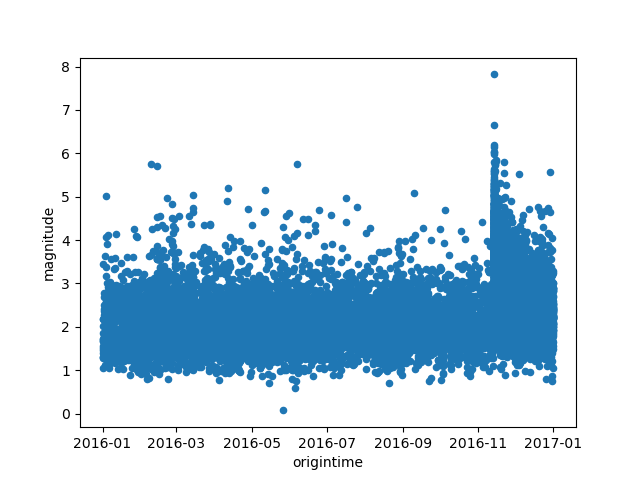

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

# Plot the data!

earthquakes.plot(x="origintime", y="magnitude", kind="scatter")
plt.show()

Here we specified the `x` argument as the column name we wanted to plot on the x-axis, and
`y` as the other column name.  Pandas has a few different plotting options that can
be specified by the `kind` argument, you can find out more about them 
[here](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html).

You can clearly see the large magnitude Kaikoura earthquake standing out from everything else.

Another helpful plot might be a histogram. The syntax for that is pretty straightforward too and here are two examples:

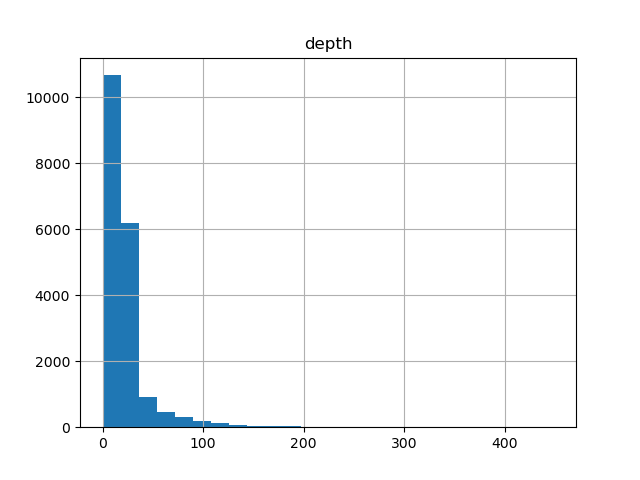

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

# Plot the data!

earthquakes.hist(column='depth', bins=25)
plt.show()

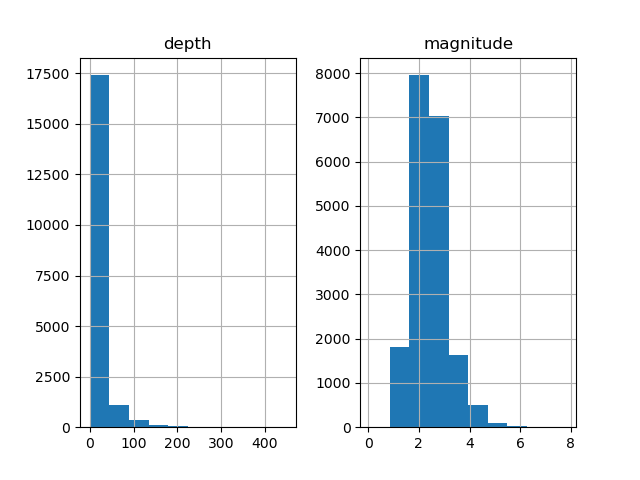

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

# Plot the data!

earthquakes.hist(column=['depth', 'magnitude'])
plt.show()

### Exercise:

Pick a specific region in New Zealand based on latitude and longitude ([this website](http://bboxfinder.com/) is
really helpful for finding bounding boxes) and get a dataframe spanning a longer period of
time.  Plot the magnitude vs. time graph for that region.

In [14]:
# Your answer here.  Call your dataframe something different to `earthquakes`

## Dataframe statistics

We can also obtain some basic stats from our dataframe, like the median magnitude...

In [15]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

# Calculate the median!
print(earthquakes["magnitude"].median())

2.378554651


... or the maximum depth:

In [16]:
print(earthquakes['depth'].max())

448.2393494


There are lots of other useful ways you can extract descriptive statistics from your dataframe, which are documented [here](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#computations-descriptive-stats).

### Exercise:

What is the mean, maximum and minimum magnitude in our dataframe?

In [17]:
# Your answer here

## Sorting the dateframe

Something we often need to do is to sort a dataset based on the value of one parameter).

In [18]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

earthquakes.sort_values(by=["latitude"], ascending=False)

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
13078,2016p711349,NaN,2016-09-20 04:46:52.374000+00:00,2016-09-20 05:01:20.887000+00:00,174.645396,-40.000798,2.503527,57.031250,M,NaN,...,NaN,automatic,nz3drx,57,57,30,0.360847,72.304007,0.772209,0.0
14698,2016p481611,earthquake,2016-06-27 04:42:46.761000+00:00,2016-07-26 03:39:50.917000+00:00,176.523422,-40.000820,2.047753,34.288498,M,NaN,...,confirmed,manual,iasp91,25,16,10,0.089791,65.493317,0.569463,0.0
13536,2016p647166,NaN,2016-08-27 10:50:45.479000+00:00,2016-08-27 10:52:16.103000+00:00,176.650818,-40.001150,1.446366,15.781250,M,NaN,...,NaN,automatic,nz3drx,10,10,5,0.163401,83.908164,0.848751,0.0
18408,2016p081480,NaN,2016-01-31 03:32:34.247000+00:00,2016-01-31 03:34:32.264000+00:00,176.548409,-40.001401,1.339061,29.843750,M,NaN,...,NaN,automatic,nz3drx,14,14,9,0.107170,70.866115,0.679501,0.0
14428,2016p517882,NaN,2016-07-10 14:47:42.773000+00:00,2016-07-10 14:49:40.374000+00:00,176.548409,-40.001401,1.784374,37.343750,M,NaN,...,NaN,automatic,nz3drx,26,26,14,0.107170,116.597350,0.537461,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,2016p886094,earthquake,2016-11-23 20:30:24.507000+00:00,2017-02-09 01:04:43.355000+00:00,165.056778,-47.957348,5.269638,12.000000,M,operator assigned,...,confirmed,manual,iasp91,18,11,16,2.107852,326.382677,0.859294,0.0
15247,2016p406569,earthquake,2016-05-30 10:19:58.997000+00:00,2016-06-22 04:59:03.521000+00:00,165.536575,-48.158676,3.995556,0.000000,M,NaN,...,confirmed,manual,iasp91,18,9,6,2.127685,325.177824,1.108503,0.0
14342,2016p533164,earthquake,2016-07-16 06:29:29.359000+00:00,2016-08-11 05:19:27.413000+00:00,165.281967,-48.350353,4.424909,12.000000,M,operator assigned,...,confirmed,manual,iasp91,21,13,5,2.380024,327.368975,1.073049,0.0
18938,2016p012387,earthquake,2016-01-05 13:59:30.348000+00:00,2016-01-19 04:16:15.310000+00:00,164.890243,-48.726803,4.122833,33.000000,M,operator assigned,...,confirmed,manual,iasp91,20,12,2,2.821467,331.785681,1.305046,0.0


You see how we have sorted the dataframe, but the index remains as it was? We can fix that so that the index is reset by passing the `ignore_index` argument to `.sort_values`:

In [19]:
earthquakes.sort_values(by=["latitude"], ascending=False, ignore_index=True)

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
0,2016p711349,NaN,2016-09-20 04:46:52.374000+00:00,2016-09-20 05:01:20.887000+00:00,174.645396,-40.000798,2.503527,57.031250,M,NaN,...,NaN,automatic,nz3drx,57,57,30,0.360847,72.304007,0.772209,0.0
1,2016p481611,earthquake,2016-06-27 04:42:46.761000+00:00,2016-07-26 03:39:50.917000+00:00,176.523422,-40.000820,2.047753,34.288498,M,NaN,...,confirmed,manual,iasp91,25,16,10,0.089791,65.493317,0.569463,0.0
2,2016p647166,NaN,2016-08-27 10:50:45.479000+00:00,2016-08-27 10:52:16.103000+00:00,176.650818,-40.001150,1.446366,15.781250,M,NaN,...,NaN,automatic,nz3drx,10,10,5,0.163401,83.908164,0.848751,0.0
3,2016p081480,NaN,2016-01-31 03:32:34.247000+00:00,2016-01-31 03:34:32.264000+00:00,176.548409,-40.001401,1.339061,29.843750,M,NaN,...,NaN,automatic,nz3drx,14,14,9,0.107170,70.866115,0.679501,0.0
4,2016p517882,NaN,2016-07-10 14:47:42.773000+00:00,2016-07-10 14:49:40.374000+00:00,176.548409,-40.001401,1.784374,37.343750,M,NaN,...,NaN,automatic,nz3drx,26,26,14,0.107170,116.597350,0.537461,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19047,2016p886094,earthquake,2016-11-23 20:30:24.507000+00:00,2017-02-09 01:04:43.355000+00:00,165.056778,-47.957348,5.269638,12.000000,M,operator assigned,...,confirmed,manual,iasp91,18,11,16,2.107852,326.382677,0.859294,0.0
19048,2016p406569,earthquake,2016-05-30 10:19:58.997000+00:00,2016-06-22 04:59:03.521000+00:00,165.536575,-48.158676,3.995556,0.000000,M,NaN,...,confirmed,manual,iasp91,18,9,6,2.127685,325.177824,1.108503,0.0
19049,2016p533164,earthquake,2016-07-16 06:29:29.359000+00:00,2016-08-11 05:19:27.413000+00:00,165.281967,-48.350353,4.424909,12.000000,M,operator assigned,...,confirmed,manual,iasp91,21,13,5,2.380024,327.368975,1.073049,0.0
19050,2016p012387,earthquake,2016-01-05 13:59:30.348000+00:00,2016-01-19 04:16:15.310000+00:00,164.890243,-48.726803,4.122833,33.000000,M,operator assigned,...,confirmed,manual,iasp91,20,12,2,2.821467,331.785681,1.305046,0.0


### Exercise:

Sort the dataframe by depth.

In [20]:
# Your answer here.

## Slicing dataframes

We can also select subsets of our dataframe; this is commonly referred to as "slicing".  Say you had downloaded the whole catalogue
and realised that you only wanted events shallower than 20 km depth. The [`.loc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) command is used to slice the dataframe to only those rows meeting the specific criteria:

In [21]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

earthquakes.loc[earthquakes["depth"] <= 20.0]

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
2,2016p989150,NaN,2016-12-31 23:39:27.175000+00:00,2016-12-31 23:41:11.310000+00:00,174.426707,-41.578959,2.388627,19.531250,M,NaN,...,NaN,automatic,nz3drx,16,16,10,0.235724,129.391293,0.285549,0.0
4,2016p989119,earthquake,2016-12-31 23:22:48.662000+00:00,2017-01-27 02:16:40.835000+00:00,173.622836,-42.139367,3.006017,11.093750,M,NaN,...,confirmed,manual,nz3drx,22,17,10,0.275581,122.998654,0.390630,0.0
5,2016p989042,NaN,2016-12-31 22:41:47.694000+00:00,2016-12-31 22:43:41.679000+00:00,172.951767,-42.647275,2.312414,14.843750,M,NaN,...,NaN,automatic,nz3drx,10,10,1,0.325838,107.281928,0.352558,0.0
6,2016p989028,NaN,2016-12-31 22:34:09.621000+00:00,2016-12-31 22:36:06.168000+00:00,174.140148,-41.659786,1.929143,5.234375,M,NaN,...,NaN,automatic,nz3drx,13,13,6,0.105667,81.927424,0.625370,0.0
7,2016p989013,NaN,2016-12-31 22:26:38.780000+00:00,2016-12-31 22:28:25.295000+00:00,174.235536,-41.724315,2.226653,9.453125,M,NaN,...,NaN,automatic,nz3drx,14,14,6,0.031084,152.380139,0.309812,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19029,2016p002946,NaN,2016-01-02 02:09:55.628000+00:00,2016-01-02 02:11:32.208000+00:00,174.943087,-40.740252,1.577955,15.781250,M,NaN,...,NaN,automatic,nz3drx,10,10,7,0.125428,216.653129,0.646318,0.0
19030,2016p002906,NaN,2016-01-02 01:48:28.745000+00:00,2016-01-02 01:50:34.978000+00:00,174.302925,-41.602844,1.420737,14.609375,M,NaN,...,NaN,automatic,nz3drx,14,14,6,0.162954,117.448687,0.236214,0.0
19045,2016p000900,NaN,2016-01-01 07:59:30.301000+00:00,2016-01-01 08:00:21.258000+00:00,171.793916,-43.459687,1.292960,11.796875,M,NaN,...,NaN,automatic,nz3drx,10,10,2,0.177892,93.836337,0.181875,0.0
19046,2016p000887,NaN,2016-01-01 07:52:50.144000+00:00,2016-01-01 07:54:33.194000+00:00,174.043760,-41.725360,1.720344,9.921875,M,NaN,...,NaN,automatic,nz3drx,15,15,7,0.125399,107.578816,0.336460,0.0


We can chain multiple conditions together using the "&" operator. Here's what we can do if we only want the earthquakes shallower than 20 km and 
larger than magnitude 4:

In [22]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

earthquakes.loc[(earthquakes["depth"] <= 20.0) &
                (earthquakes["magnitude"] > 4.0)]

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
86,2016p986310,earthquake,2016-12-30 22:25:59.852000+00:00,2017-01-26 09:16:59.271000+00:00,173.377518,-42.537266,4.056910,14.897259,M,NaN,...,confirmed,manual,iasp91,46,42,111,0.170173,127.203983,0.779050,0.000000
333,2016p981419,earthquake,2016-12-29 03:00:20.399000+00:00,2017-01-26 03:41:54.265000+00:00,174.434244,-41.548320,4.644331,13.203125,M,NaN,...,confirmed,manual,nz3drx,43,32,9,0.262768,127.535821,0.608801,0.000000
344,2016p981371,earthquake,2016-12-29 02:34:33.905000+00:00,2017-01-26 03:24:55.941000+00:00,174.461866,-41.549133,5.559761,16.015625,MLv,NaN,...,confirmed,manual,nz3drx,56,42,78,0.275809,126.663161,0.641470,0.148870
420,2016p979398,earthquake,2016-12-28 09:03:16.342000+00:00,2017-01-26 02:46:38.519000+00:00,174.209501,-41.795288,4.136149,12.734375,M,NaN,...,confirmed,manual,nz3drx,41,34,78,0.044757,142.722746,0.670685,0.000000
512,2016p977108,earthquake,2016-12-27 12:43:09.727000+00:00,2017-01-26 00:53:25.583000+00:00,173.443544,-42.343582,4.163341,9.453125,M,NaN,...,confirmed,manual,nz3drx,27,22,15,0.100765,59.036056,0.513083,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18025,2016p119534,earthquake,2016-02-14 05:27:50.618000+00:00,2016-02-26 03:09:31.770000+00:00,172.760727,-43.525723,4.312076,4.849864,M,NaN,...,confirmed,manual,iasp91,44,32,8,0.038127,112.577927,0.578138,0.000000
18081,2016p118953,earthquake,2016-02-14 00:14:52.759000+00:00,2016-02-26 01:19:20.931000+00:00,172.659180,-43.447514,4.533571,8.000000,ML,operator assigned,...,confirmed,manual,iasp91,16,10,2,0.003070,115.233965,0.646716,0.313392
18082,2016p118944,earthquake,2016-02-14 00:13:43.988000+00:00,2016-02-19 03:33:27.262000+00:00,172.754593,-43.497318,5.701799,8.000000,M,operator assigned,...,confirmed,manual,iasp91,15,9,7,0.221172,114.436289,0.453791,0.000000
18494,2016p072907,earthquake,2016-01-27 23:24:41.920000+00:00,2016-02-03 01:56:02.783000+00:00,172.503479,-43.549858,4.105753,6.491029,M,NaN,...,confirmed,manual,iasp91,46,30,13,0.022921,54.258331,0.648395,0.000000


### Exercise:

Select earthquakes deeper than 80 km depth between -42 degrees latitude and -44 degrees latitude.

In [23]:
# Your answer here

## Editing dataframes

Sometimes you need to add or remove rows of columns from your dataframe, or you might want to change how the dataframe is indexed. This kind of dataframe editing is relatively straightforward in Pandas, although there are often multiple ways to accomplish the same goal. In this section we will try to demonstrate some of these methods.

### Removing columns

Say we didn't care about the "modificationtime" column - we can use the [`.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method to get rid of columns or rows - in this case we can pass `columns="modificationtime"` to remove that column:

In [24]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})
column_mapper = dict()
for column in earthquakes.columns:
    # Use the strip method to remove spaces
    column_mapper[column] = column.strip()
    
earthquakes = earthquakes.rename(columns=column_mapper)

earthquakes = earthquakes.drop(columns="modificationtime")
print(earthquakes.columns)

Index(['publicid', 'eventtype', 'origintime', 'longitude', 'latitude',
       'magnitude', 'depth', 'magnitudetype', 'depthtype', 'evaluationmethod',
       'evaluationstatus', 'evaluationmode', 'earthmodel', 'usedphasecount',
       'usedstationcount', 'magnitudestationcount', 'minimumdistance',
       'azimuthalgap', 'originerror', 'magnitudeuncertainty'],
      dtype='object')


If we know that we only want a few columns then a simpler way than dropping lots of columns might be to just read in the columns we care about, and we can do that in `.read_csv`:

In [25]:
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    usecols=["origintime", "magnitude", "latitude", "longitude", "depth", "publicid"],
    parse_dates=["origintime"],
    dtype={"publicid": str})

print(earthquakes)

          publicid                       origintime   longitude   latitude  \
0      2016p989175 2016-12-31 23:52:52.120000+00:00  173.524601 -42.363461   
1      2016p989152 2016-12-31 23:40:47.629000+00:00  172.804712 -41.325883   
2      2016p989150 2016-12-31 23:39:27.175000+00:00  174.426707 -41.578959   
3      2016p989125 2016-12-31 23:26:14.146000+00:00  173.627594 -42.109469   
4      2016p989119 2016-12-31 23:22:48.662000+00:00  173.622836 -42.139367   
...            ...                              ...         ...        ...   
19047  2016p000726 2016-01-01 06:26:56.460000+00:00  173.667573 -41.307984   
19048  2016p000437 2016-01-01 03:52:50.733000+00:00  176.402064 -40.547843   
19049  2016p000344 2016-01-01 03:03:31.244000+00:00  174.136581 -40.906197   
19050  2016p000309 2016-01-01 02:45:04.924000+00:00  175.899471 -40.088561   
19051  2016p000001 2016-01-01 00:00:56.034000+00:00  175.849863 -40.644718   

       magnitude      depth  
0       2.264764  24.218750  
1  

We often find that we want to add more information to our dataframes, for example we might want to add a column that is the distance away from some place we care about, say VUW... We will talk more about applying functions to dataframes in a couple of notebooks time, but for now we will import a function for calculating the distance and loop through our dataframe:

In [26]:
from helpers.geodetics import globe_distance
import pandas as pd

earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    usecols=["origintime", "magnitude", "latitude", "longitude", "depth", "publicid"],
    parse_dates=["origintime"],
    dtype={"publicid": str})

vuw_lat, vuw_lon = -41.2901, 174.768

distances = []
for row in earthquakes.itertuples():
    distance = globe_distance(vuw_lat, vuw_lon, row.latitude, row.longitude)
    distances.append(distance)
    
print(distances[0:10])

[157.73924, 164.45477, 42.92904, 131.50022, 134.08535, 213.03726, 66.60385, 65.58815, 63.18007, 128.92565]


To add that column into our dataframe we can simply assign a new column as if the dataframe was a dictionary using syntax like:

`dataframe["new_column"] = distances`


In [27]:
earthquakes["distance"] = distances

earthquakes.describe()

,longitude,latitude,magnitude,depth,distance
count,19052.000000,19052.000000,19052.000000,19052.000000,19052.000000
mean,173.927960,-41.857320,2.434557,22.082589,154.070766
std,1.646444,1.060164,0.680608,24.000792,130.919280
min,164.890243,-48.808189,0.073918,0.000000,0.862880
25%,173.483917,-42.365864,1.991765,9.712986,72.290830
50%,174.073111,-41.775154,2.378555,15.781250,126.328920
75%,174.411258,-41.213903,2.771011,24.921875,179.106002
max,179.810989,-40.000798,7.820380,448.239349,1136.462360


Using all of the above - what is the largest magnitude earthquake that happened within 100 km of VUW in our data period?

In [28]:
# Your answer here - hint, use slicing to get events within 100km and find the max of the magnitude column.

## Reading Excel data

So far we have just been reading .csv files, but up to this point in your University career, you have probably been using Excel a lot. There is a time and place for using Excel, but that time and place is rarely when doing data-intensive analyses: remember to keep your data sacred! Don't run the risk of overwriting your hard earned data, don't hide equations behind cells, and don't copy-and-paste (remember DRY).

So you are now an enlightened 400-level student who knows better, what do you do now with all those data in Excel speadsheets!? Do not despair! You can read all sorts with Pandas and apply all your new knowledge to your old data (yay!). To read Excel data we need to have installed an extra package (which is included in this environment already) called `openpyxl` - Pandas will call this under the hood to read Excel spreadsheets.

Lets grab the tephraNZ dataset from [Hopkins et al. 2021](https://gchron.copernicus.org/articles/3/465/2021/gchron-3-465-2021.html). Jenni and her team archived the data as excel tables in the supplement to this paper, as well as putting the data in proper databases like [PetLab](https://pet.gns.cri.nz/#/) and their submission to [EarthChem](https://ecl.earthchem.org/view.php?id=1724), although neither seems to offer a programmatic interface (correct me if I'm wrong). We will just use the supplementary data as a showcase of reading Excel data, and playing with formating.

We need to do some playing around to get the supplement to the paper which is downloaded as a zip-archive. The cell below downloads the zipfile and extracts the contents. Note that if you want to download and extract zipfiles from the web, the function provided might be useful to you! It checks that the actions taken are safe as well, to avoid extracting files to other locations on your computer by accident... or through someone elses malicious intent.

In [29]:
from helpers.get_data import download_and_extract

url = "https://gchron.copernicus.org/articles/3/465/2021/gchron-3-465-2021-supplement.zip"

download_and_extract(url, "data/TephraNZ")

This should have made a TephraNZ directory in your data directory. The file we want to look at is the `TephraNZ_Tables_FINAL4.xlsx`. Lets open that and have a look using Pandas!

In [30]:
tephranz = pd.read_excel("data/TephraNZ/TephraNZ_Tables_FINAL4.xlsx")

tephranz

,Table 1. Overview of the foundation tephra included in TephraNZ database,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tephra name,Alternative name(s),Caldera source,Smithsonian GVP number,"Age (cal. yr BP, 2sd) (unless otherwise shown)",Dating method*,Age reference,Proximal/ distal,Long.,Lat.,Site number (Fig. 1),Site description (Fig. 1),Date of EPMA analysis,Date of LA-ICP-MS analysis
2,Kaharoa,NaN,Okataina,241050,636 ± 12,C14 wiggle match,1,P,176.530451,-38.309116,1,Ash Pit Road,10_12_19,28_01_20 (run#1)
3,Taupō,Unit Y,Taupō,241070,1718 ± 10,C14 wiggle match,"2, 3",P,176.19934,-38.747262,2,SH 5,10_12_19,28_01_20 (run#1)
4,Waimihia,Unit S,Taupō,241070,3382 ± 50,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#1)
5,Unit K (Taupō series),NaN,Taupō,241070,5088 ± 73,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#2)
6,Whakatane,NaN,Okataina,241050,5542 ± 48,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,176.530451,-38.309116,1,Ash Pit Road,11_12_19,28_01_20 (run#2)
8,Tuhua,NaN,Mayor Island,NaN,7637 ± 100,C14 Bayes model,5,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,28_01_20 (run#2)
9,Mamaku,NaN,Okataina,241050,7992 ± 58,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,29_01_20 (run#3)


This looks ... odd. We haven't got useful column headers, and there is some caption in the header... we need to do some admin to make this useful to us.

One more thing: there are multiple sheets in the Excel workbook - by default Pandas will load just the zeroth sheet. If you want to load a different sheet you can pass the sheet number or name:

In [31]:
tephranz_2 = pd.read_excel("data/TephraNZ/TephraNZ_Tables_FINAL4.xlsx", sheet_name=1)

tephranz_2

,"Table 2. Average and standard deviation for all tephra, see SM Table 1 for full dataset.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,"Table 3. (cont) Average and standard deviation for all tephra, see SM Table 1 for full dataset..2",Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tephra name,NaN,SiO2 (wt%),TiO2 (wt%),Al2O3 (wt%),FeOt (wt%),MnO (wt%),MgO (wt%),CaO (wt%),Na2O (wt%),...,Tephra name,NaN,Yb (ppm),Lu (ppm),Hf (ppm),Ta (ppm),W (ppm),Pb (ppm),Th (ppm),U (ppm)
2,Kaharoa,Average,77.892125,0.089009,12.667798,0.85348,0.070251,0.060791,0.621909,3.753886,...,Kaharoa,Average,3.5575,0.876875,3.066875,0.758,1.58625,18.13375,11.631875,3.24
3,n=24 (16),stdev,0.181456,0.045114,0.160948,0.0895,0.021228,0.026268,0.184303,0.177577,...,n=24 (16),stdev,1.331243,0.320535,0.774181,0.184312,0.54181,4.532588,3.0806,0.89848
4,Taupo Y5,Average,76.027486,0.235864,13.159158,1.83266,0.098356,0.18296,1.395555,4.053673,...,Taupo Y5,Average,2.9375,0.7403,4.3505,0.53285,1.452,17.3245,9.155,2.41905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,D = distal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D = distal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,K = Kaipo Bog sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,K = Kaipo Bog sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,"XXX = Pillans et al., 2005 sample number",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"XXX = Pillans et al., 2005 sample number",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,"n = number of shards analysed, (trace in paren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"n = number of shards analysed, (trace in paren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets get back to reading in that first sheet in a more useful way. First we need to drop the header and the footer. There are two rows of un-needed header info (the caption and a blank line), and seven rows of references at the end (which are vital, but not what we need for analysis):

In [32]:
tephranz = pd.read_excel("data/TephraNZ/TephraNZ_Tables_FINAL4.xlsx", header=2, skipfooter=7)

tephranz

,Tephra name,Alternative name(s),Caldera source,Smithsonian GVP number,"Age (cal. yr BP, 2sd) (unless otherwise shown)",Dating method*,Age reference,Proximal/ distal,Long.,Lat.,Site number (Fig. 1),Site description (Fig. 1),Date of EPMA analysis,Date of LA-ICP-MS analysis
0,Kaharoa,NaN,Okataina,241050.0,636 ± 12,C14 wiggle match,1,P,176.530451,-38.309116,1,Ash Pit Road,10_12_19,28_01_20 (run#1)
1,Taupō,Unit Y,Taupō,241070.0,1718 ± 10,C14 wiggle match,"2, 3",P,176.199340,-38.747262,2,SH 5,10_12_19,28_01_20 (run#1)
2,Waimihia,Unit S,Taupō,241070.0,3382 ± 50,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#1)
3,Unit K (Taupō series),NaN,Taupō,241070.0,5088 ± 73,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#2)
4,Whakatane,NaN,Okataina,241050.0,5542 ± 48,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,176.530451,-38.309116,1,Ash Pit Road,11_12_19,28_01_20 (run#2)
6,Tuhua,NaN,Mayor Island,NaN,7637 ± 100,C14 Bayes model,5,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,28_01_20 (run#2)
7,Mamaku,NaN,Okataina,241050.0,7992 ± 58,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,29_01_20 (run#3)
8,Rotoma,NaN,Okataina,241050.0,9472 ± 40,C14 Bayes model,4,P,176.530451,-38.309116,1,Ash Pit Road,11_12_19,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,29_01_20 (run#3)


Much better, but there are lots of NaNs in there (Not a Number) where there is missing information for that cell. Some of these are because there actually isn't data, but some are there because there are merged cells in the spreadsheet. The default way Pandas handles this is to only assign the merged cell value to the first row of a multi-row merged cell. We really want that filled into both cells. To do with we can use the [`.ffill`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html) method on the columns that we know have merged values. This is pretty messy, but this is often something that needs to be done to actually read in real data!

In [33]:

tephranz = pd.read_excel("data/TephraNZ/TephraNZ_Tables_FINAL4.xlsx", header=2, skipfooter=7)

# Columns that need to be filled
columns_to_merge = ["Tephra name", "Caldera source", "Smithsonian GVP number", 
                    "Age (cal. yr BP, 2sd) (unless otherwise shown)", "Dating method*", 
                    "Age reference", "Proximal/ distal"]
for col in columns_to_merge:
    tephranz[col] = tephranz[col].ffill()

tephranz

,Tephra name,Alternative name(s),Caldera source,Smithsonian GVP number,"Age (cal. yr BP, 2sd) (unless otherwise shown)",Dating method*,Age reference,Proximal/ distal,Long.,Lat.,Site number (Fig. 1),Site description (Fig. 1),Date of EPMA analysis,Date of LA-ICP-MS analysis
0,Kaharoa,NaN,Okataina,241050.0,636 ± 12,C14 wiggle match,1,P,176.530451,-38.309116,1,Ash Pit Road,10_12_19,28_01_20 (run#1)
1,Taupō,Unit Y,Taupō,241070.0,1718 ± 10,C14 wiggle match,"2, 3",P,176.199340,-38.747262,2,SH 5,10_12_19,28_01_20 (run#1)
2,Waimihia,Unit S,Taupō,241070.0,3382 ± 50,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#1)
3,Unit K (Taupō series),NaN,Taupō,241070.0,5088 ± 73,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,10_12_19,28_01_20 (run#2)
4,Whakatane,NaN,Okataina,241050.0,5542 ± 48,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,NaN
5,Whakatane,NaN,Okataina,241050.0,5542 ± 48,C14 Bayes model,4,P,176.530451,-38.309116,1,Ash Pit Road,11_12_19,28_01_20 (run#2)
6,Tuhua,NaN,Mayor Island,241050.0,7637 ± 100,C14 Bayes model,5,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,28_01_20 (run#2)
7,Mamaku,NaN,Okataina,241050.0,7992 ± 58,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,29_01_20 (run#3)
8,Rotoma,NaN,Okataina,241050.0,9472 ± 40,C14 Bayes model,4,P,176.530451,-38.309116,1,Ash Pit Road,11_12_19,NaN
9,Rotoma,NaN,Okataina,241050.0,9472 ± 40,C14 Bayes model,4,D,176.224215,-38.842063,3,Kaipo Bog,11_12_19,29_01_20 (run#3)


In your assignment you might find that you have to work with data like this - remember to come back and look at this notebook! You may find that the [`.ffill`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html) method is useful for your dataset, but you might also just want to get rid of nan values using [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html), which is similar, but instead of filling the nan values with something, it just removes that row or column...